In [1]:
from PTL.data_process import (
    load_and_process_data,
    filter_data_by_cata_test,
    normalize_features_and_labels,
    stratified_split,
    filter_and_process_data,
    prepare_datasets,
)
from PTL.model import (
    create_soc_estimator,
    create_feature_extractor,
    create_task_net,
    CoralModel,
)
from PTL.utils import (
    set_random_seeds,
    limit_threads,
    coral_loss,
    calculate_mape,
    calculate_maxpe,
    evaluate_soc_predictions,
)
from PTL.evaluator import evaluate_and_plot
from PTL.visualization import plot_losses, plot_feature_distribution
import numpy as np
import tensorflow as tf

In [2]:
# 1. 设置随机种子和限制线程
set_random_seeds()  # 设置随机种子
limit_threads()  # 限制线程数

# 示例数据加载（假设之前的步骤已生成 data）
file_paths = [
    "data/processed/combined_augmented_data_output_Cylind21.xlsx",
    "data/processed/combined_augmented_data_output_Pouch31.xlsx",
    "data/processed/combined_augmented_data_output_Pouch52.xlsx",
]

# 加载并合并数据
combined_data = load_and_process_data(file_paths)

# 定义要测试的Cata值和样本比例
Cata_to_test = 2
sample_proportion = 3

# 调用过滤函数
Fts, SOH, SOC, Cata = filter_data_by_cata_test(
    combined_data, Cata_to_test, sample_proportion
)

# 假设 Fts, SOH, SOC 已经被正确赋值
(Fts_normalized, SOH_normalized, SOC_normalized), (
    feature_scaler,
    label_scaler_SOH,
    SOC_scaler,
) = normalize_features_and_labels(Fts, SOH, SOC)

# 查看结果
print("Normalized Features (Fts):", Fts_normalized.shape)
print("Normalized SOH:", SOH_normalized.shape)
print("Normalized SOC:", SOC_normalized.shape)

Normalized Features (Fts): (20100, 21)
Normalized SOH: (20100,)
Normalized SOC: (20100,)


In [3]:
# 调用分层划分函数
X_train, X_test, y_train, y_test, SOC_train, SOC_test, Cata_train, Cata_test = (
    stratified_split(Fts, SOH, SOC, Cata)
)

# 打印划分后的数据形状
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training SOH Shape:", y_train.shape)
print("Testing SOH Shape:", y_test.shape)
print("Training SOC Shape:", SOC_train.shape)
print("Testing SOC Shape:", SOC_test.shape)
print("Training Cata Shape:", Cata_train.shape)
print("Testing Cata Shape:", Cata_test.shape)

Training Features Shape: (16080, 21)
Testing Features Shape: (4020, 21)
Training SOH Shape: (16080,)
Testing SOH Shape: (4020,)
Training SOC Shape: (16080,)
Testing SOC Shape: (4020,)
Training Cata Shape: (16080,)
Testing Cata Shape: (4020,)


In [4]:
# # 过滤 Cata=1 数据，源域
# X_train_Cata1, y_train_Cata1, SOC_train_Cata1 = filter_samples_by_cata_value(
#     X_train, y_train, SOC_train, Cata_train, 1
# )
# X_test_Cata1, y_test_Cata1, SOC_test_Cata1 = filter_samples_by_cata_value(
#     X_test, y_test, SOC_test, Cata_test, 1
# )

# # 过滤 Cata=2 数据，目标域
# X_train_Cata2, y_train_Cata2, SOC_train_Cata2 = filter_samples_by_cata_value(
#     X_train, y_train, SOC_train, Cata_train, 2
# )

# # 打印筛选后的数据形状
# print("X_train_Cata1.shape", X_train_Cata1.shape)
# print("y_train_Cata1.shape", y_train_Cata1.shape)
# print("SOC_train_Cata1.shape", SOC_train_Cata1.shape)
# print("X_test_Cata1.shape", X_test_Cata1.shape)
# print("y_test_Cata1.shape", y_test_Cata1.shape)
# print("SOC_test_Cata1.shape", SOC_test_Cata1.shape)
# print("X_train_Cata2.shape", X_train_Cata2.shape)
# print("y_train_Cata2.shape", y_train_Cata2.shape)
# print("SOC_train_Cata2.shape", SOC_train_Cata2.shape)

In [5]:
# # 扩展和下采样
# X_train_Cata2, y_train_Cata2, SOC_train_Cata2 = extend_and_downsample(
#     X_train_Cata1,
#     y_train_Cata1,
#     SOC_train_Cata1,
#     X_train_Cata2,
#     y_train_Cata2,
#     SOC_train_Cata2,
#     sample_proportion=3,
# )
# # 打印结果
# print(f"Train Features (Cata=2) after extension and downsampling: {X_train_Cata2.shape}")
# print(f"Train SOH (Cata=2) after extension and downsampling: {y_train_Cata2.shape}")
# print(f"Train SOC (Cata=2) after extension and downsampling: {SOC_train_Cata2.shape}")

# # 准备测试数据
# X_test_Cata1, y_test_Cata1, SOC_test_Cata1 = prepare_test_data(
#     X_test, y_test, SOC_test, Cata_test, 1
# )
# X_test_Cata2, y_test_Cata2, SOC_test_Cata2 = prepare_test_data(
#     X_test, y_test, SOC_test, Cata_test, 2
# )
# print(f"X_test_Cata1.shape: {X_test_Cata1.shape}")
# print(f"y_test_Cata1.shape: {y_test_Cata1.shape}")
# print(f"SOC_test_Cata1.shape: {SOC_test_Cata1.shape}")
# print(f"X_test_Cata2.shape: {X_test_Cata2.shape}")
# print(f"y_test_Cata2.shape: {y_test_Cata2.shape}")
# print(f"SOC_test_Cata2.shape: {SOC_test_Cata2.shape}")

In [6]:
(
    X_train_Cata1,
    y_train_Cata1,
    SOC_train_Cata1,
    X_test_Cata1,
    y_test_Cata1,
    SOC_test_Cata1,
    X_train_Cata2,
    y_train_Cata2,
    SOC_train_Cata2,
    X_test_Cata2,
    y_test_Cata2,
    SOC_test_Cata2,
) = filter_and_process_data(
    X_train,
    y_train,
    SOC_train,
    X_test,
    y_test,
    SOC_test,
    Cata_train,
    Cata_test,
    Cata_to_test,
    sample_proportion,
)

The size of target domain training data is: 1786


In [7]:
# 创建SOC估计模型，输入维度为21
soc_estimator = create_soc_estimator(input_dim=21)

# 创建特征提取器，输入维度为21
feature_extractor = create_feature_extractor(input_dim=21)

# 创建回归任务网络，输入维度为21
task_net = create_task_net(input_dim=21)

# # 打印模型摘要以查看结构
# print("SOC Estimator Model Summary:")
# soc_estimator.summary()

# print("\nFeature Extractor Model Summary:")
# feature_extractor.summary()

# print("\nTask Network Model Summary:")
# task_net.summary()

# Compile model
model = CoralModel(soc_estimator, feature_extractor, task_net)


optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer)

In [8]:
# 假设你已经准备好数据
# 这里示范如何调用该函数来准备数据
print("##### DEBUG #####")
print(
    f"X_train_Cata1: {X_train_Cata1.shape},\n SOC_train_Cata1: {SOC_train_Cata1.shape},\n y_train_Cata1: {y_train_Cata1.shape},\n X_train_Cata2: {X_train_Cata2.shape},\n SOC_train_Cata2: {SOC_train_Cata2.shape},\n y_train_Cata2: {y_train_Cata2.shape}"
)
dataset_combined = prepare_datasets(
    X_train_Cata1,
    SOC_train_Cata1,
    y_train_Cata1,
    X_train_Cata2,
    SOC_train_Cata2,
    y_train_Cata2,
    batch_size=128,
)
print("##### DEBUG #####")

##### DEBUG #####
X_train_Cata1: (5360, 21),
 SOC_train_Cata1: (5360, 1),
 y_train_Cata1: (5360,),
 X_train_Cata2: (1786, 21),
 SOC_train_Cata2: (1786, 1),
 y_train_Cata2: (1786,)
##### DEBUG #####


In [9]:
# 用于记录训练过程中的各项损失
total_loss_list = []
task_loss_source_list = []
task_loss_target_list = []
coral_loss_list = []
soc_loss_source_list = []
soc_loss_target_list = []

# Train model
# for epoch in range(5000):
for epoch in range(50):
    for batch in dataset_combined:
        data_source, data_target = batch
        x_source, soc_source, y_source = data_source
        x_target, soc_target, y_target = data_target
        # print("##### DEBUG #####")
        # print(
        #     f"x_source: {x_source.shape},\n soc_source: {soc_source.shape},\n y_source: {y_source.shape},\n x_target: {x_target.shape},\n soc_target: {soc_target.shape},\n y_target: {y_target.shape}"
        # )
        # print("##### DEBUG #####")
        loss_metrics = model.train_step(
            (x_source, soc_source, y_source, x_target, soc_target, y_target)
        )
        # print("##### DEBUG #####")
        # print(model.summary())

    print(
        f"Epoch {epoch}: Loss = {loss_metrics['loss']}, SOC Loss Source = {loss_metrics['soc_loss_source']}, SOC Loss Target = {loss_metrics['soc_loss_target']}, Task Loss Source = {loss_metrics['task_loss_source']}, Task Loss Target = {loss_metrics['task_loss_target']}, Coral Loss = {loss_metrics['coral_loss']}"
    )

    # Append the losses
    total_loss_list.append(loss_metrics["loss"])
    task_loss_source_list.append(loss_metrics["task_loss_source"])
    task_loss_target_list.append(loss_metrics["task_loss_target"])
    coral_loss_list.append(loss_metrics["coral_loss"])
    soc_loss_source_list.append(loss_metrics["soc_loss_source"])
    soc_loss_target_list.append(loss_metrics["soc_loss_target"])

Epoch 0: Loss = 177.46554565429688, SOC Loss Source = 587.1121826171875, SOC Loss Target = 577.9321899414062, Task Loss Source = 0.019594388082623482, Task Loss Target = 0.022505009546875954, Coral Loss = 3.044405460357666
Epoch 1: Loss = 23.9732723236084, SOC Loss Source = 82.54045104980469, SOC Loss Target = 78.13650512695312, Task Loss Source = 0.007858195342123508, Task Loss Target = 0.009006141684949398, Coral Loss = 0.03337661176919937
Epoch 2: Loss = 4.5067219734191895, SOC Loss Source = 16.63984489440918, SOC Loss Target = 14.00278377532959, Task Loss Source = 0.007514365948736668, Task Loss Target = 0.008551554754376411, Coral Loss = 0.005884288344532251
Epoch 3: Loss = 1.580735445022583, SOC Loss Source = 6.480465888977051, SOC Loss Target = 4.518308639526367, Task Loss Source = 0.006958821788430214, Task Loss Target = 0.00777951767668128, Coral Loss = 0.0014448133297264576
Epoch 4: Loss = 1.044352650642395, SOC Loss Source = 4.509889602661133, SOC Loss Target = 2.84639310836

42/42 [==============================] - 0s 1ms/step
Source Domain: MAPE = 0.5263853050475604, MaxPE = 2.002736665003542
Source Domain: Pearson Correlation = -0.7886734163201221
42/42 [==============================] - 0s 989us/step
Source Domain SOC: MAPE = 180.79361558080527, MaxPE = 187.93960652426483
Source Domain SOC: Pearson Correlation = -0.7889178434487218
42/42 [==============================] - 0s 1ms/step
Target Domain: MAPE = 0.525490547647161, MaxPE = 1.9858377509767267
Target Domain: Pearson Correlation = -0.7845528698005025
42/42 [==============================] - 0s 823us/step
Target Domain SOC: MAPE = 180.75461749254168, MaxPE = 187.4445810797173
Target Domain SOC: Pearson Correlation = -0.7847899636999839


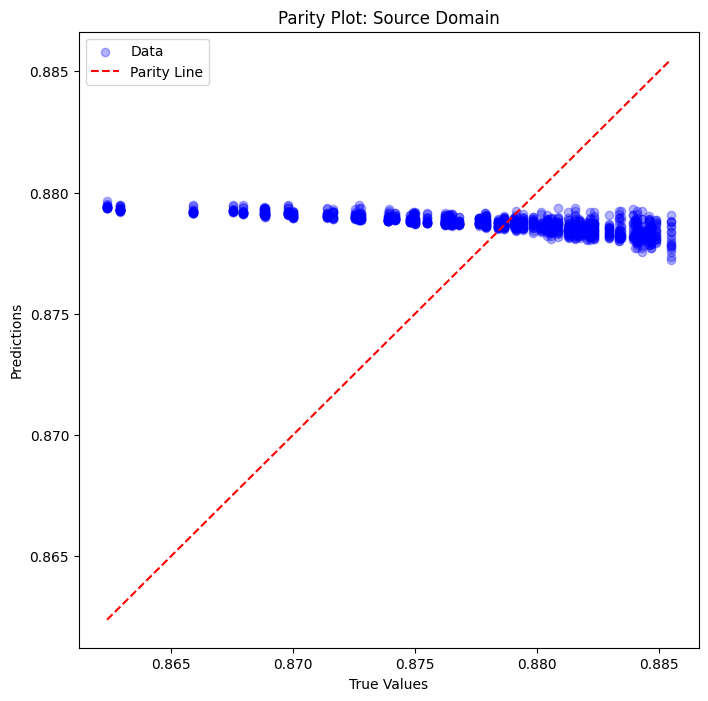

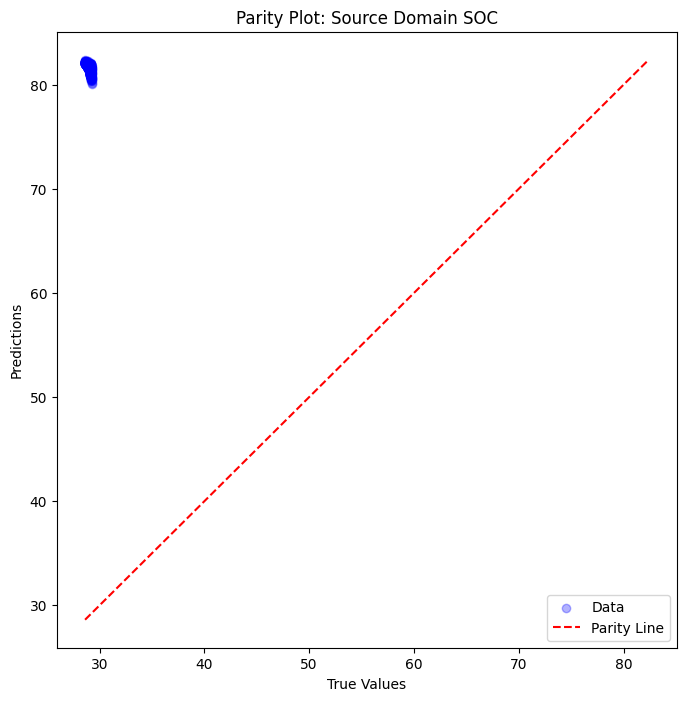

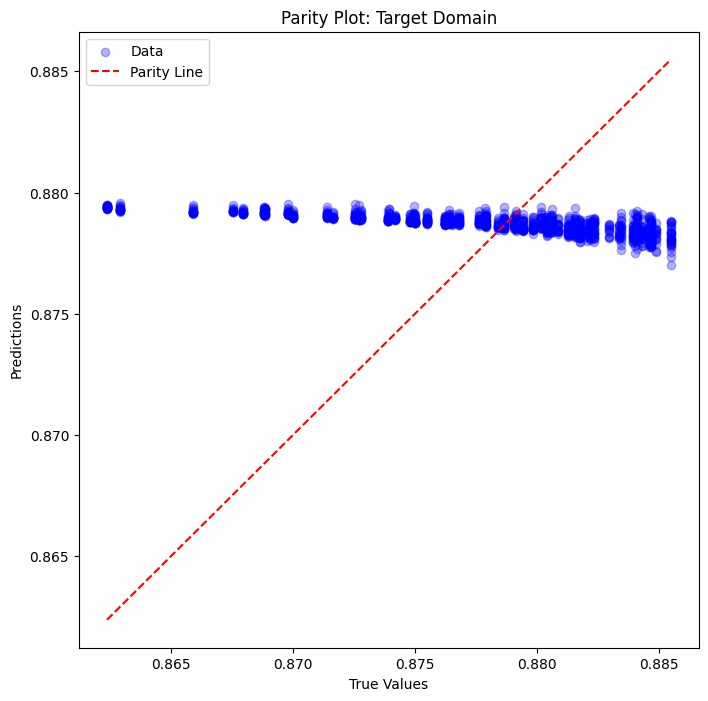

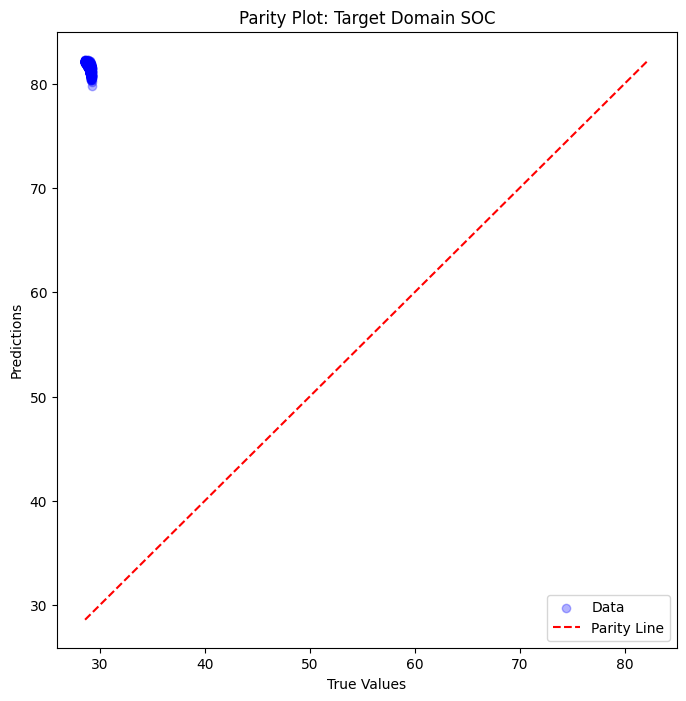

In [10]:
# 调用函数进行源领域和目标领域的预测、评估与绘图
# 对源领域进行评估
evaluate_and_plot(
    model,
    X_test_Cata1,
    y_test_Cata1,
    label_scaler_SOH,
    SOC_scaler,
    soc_estimator=model.soc_estimator,
    domain_name="Source Domain",
)

# 对目标领域进行评估
evaluate_and_plot(
    model,
    X_test_Cata2,
    y_test_Cata2,
    label_scaler_SOH,
    SOC_scaler,
    soc_estimator=model.soc_estimator,
    domain_name="Target Domain",
)

In [11]:
# 评估源域SOC
mape_soc_source, maxpe_soc_source = evaluate_soc_predictions(
    model, X_test_Cata1, SOC_test_Cata1, SOC_scaler, domain="Source"
)

# 评估目标域SOC
mape_soc_target, maxpe_soc_target = evaluate_soc_predictions(
    model, X_test_Cata2, SOC_test_Cata2, SOC_scaler, domain="Target"
)

42/42 [==============================] - 0s 828us/step
Source Domain SOC: MAPE = 3.22%, MaxPE = 23.87%
42/42 [==============================] - 0s 777us/step
Target Domain SOC: MAPE = 3.41%, MaxPE = 31.38%


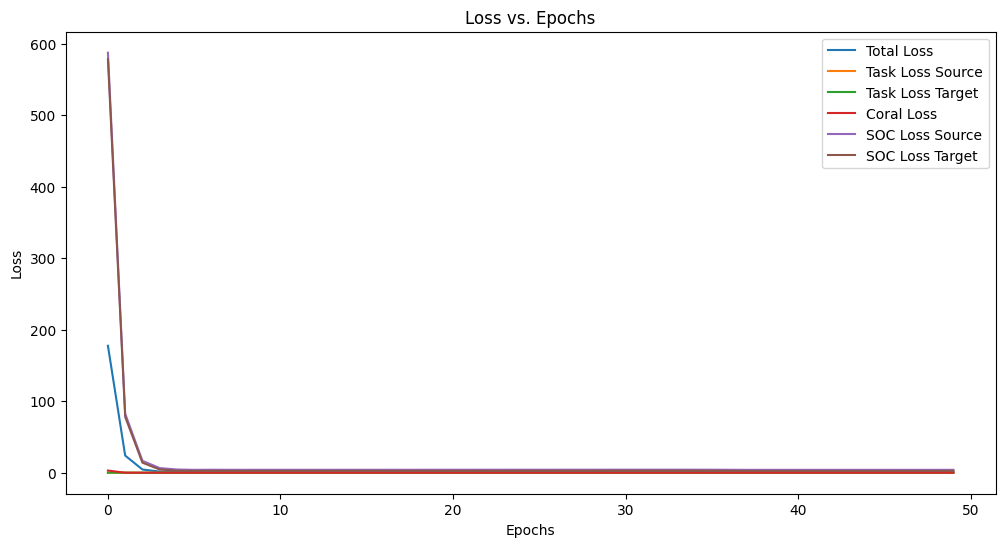

42/42 [==============================] - 0s 967us/step


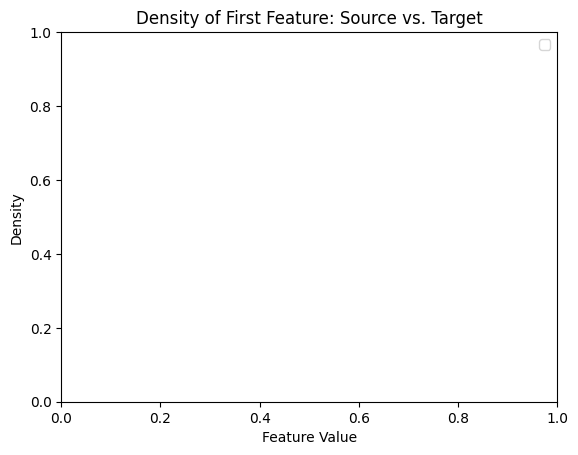

In [12]:
# 调用绘制损失函数图像的函数
plot_losses(
    total_loss_list,
    task_loss_source_list,
    task_loss_target_list,
    coral_loss_list,
    soc_loss_source_list,
    soc_loss_target_list,
)

# 调用绘制特征分布图像的函数
plot_feature_distribution(model, X_test_Cata1, X_test_Cata2, feature_id=0)